In [5]:
import pandas as pd

# 加载 Excel 文件
# excel_path = './data/beiyou_excel/chaoyang_retrospective_233.xlsx'
excel_path = './data/beiyou_excel/luhe_323.xls'
labels_df = pd.read_excel(excel_path)

# 查看标签数据框架
print(labels_df.head())

      病例号    年龄 是否＞45 神经侵犯 脉管癌栓  T分期  淋巴结转移  N分期   TNM分期 侧别  ER  PR  HR  \
0  319946  72.0     是    -    -  1.0    3.0  1.0  T1N1M0  R  95  10   1   
1  325668  67.0     是  NaN  NaN  2.0    0.0  0.0  T2N0M0  L   -   -   2   
2  326188  63.0     是  NaN  NaN  2.0    0.0  0.0  T2N0M0  R  20   5   1   
3  343584  48.0     是    +    -  1.0    0.0  0.0  T1N0M0  L   -   -   2   
4  344957  85.0     是    -    -  2.0    0.0  0.0  T2N0M0  R  90  60   1   

  ki67（%） HER2  分子分型  
0       5    2     1  
1      10    2     5  
2       5    2     2  
3      20    2     5  
4      30    2     2  


[[7.52316385e-37 2.73851167e-11 8.76272999e-10 ... 8.58043600e-03
  7.75647024e-03 6.99705537e-03]
 [2.52238331e-14 2.09302908e-10 4.36030145e-09 ... 9.24939755e-03
  8.37390125e-03 7.56600406e-03]
 [2.73851167e-11 8.76272999e-10 6.69743461e-09 ... 9.95944720e-03
  9.03004594e-03 8.17136839e-03]
 ...
 [2.48705205e-02 2.69456599e-02 2.91570425e-02 ... 3.64725388e-08
  9.41982403e-09 1.46319767e-09]
 [2.33867001e-02 2.53629796e-02 2.74706595e-02 ... 1.35625005e-08
  2.46272469e-09 1.81132789e-10]
 [2.19745766e-02 2.38555707e-02 2.58632246e-02 ... 3.94634192e-09
  3.91502303e-10 4.68052593e-12]]


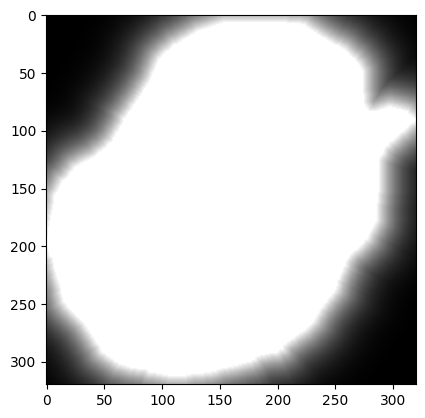

In [ ]:
import os
import matplotlib.pyplot as plt
import importlib
import module.load_data
importlib.reload(module.load_data)
from module.load_data import load_dcm, load_nii 

# dir = "./data/chaoyang_huigu/BAILIANDI RCC"
dir = "./data/chaoyang_huigu/BAILIANDI RMLO"

# img_nib ,_,_= load_nii(os.path.join(dir, "1.nii.gz"))
img_nib,_,_= load_nii(os.path.join(dir, "1.nii.gz"))

# #查看img_nib中最大值，以及他的位置
# print(np.max(img_nib))
# print(np.where(img_nib == np.max(img_nib)))

# img_dcm = pydicom.dcmread(os.path.join(dir, "ser97311img00002.dcm"))
img_dcm = load_dcm(os.path.join(dir, "ser97311img00001.dcm"))

plt.imshow(img_dcm, cmap='gray')
# plt.savefig("./image/test20.png")
# plt.imshow(img_nib, cmap='gray')

In [3]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import cv2

from module.load_data import load_img

def process_images_for_patients(base_path, target_size = (224, 224),a =0):

    # 获取所有病人文件夹
    all_folders = sorted([f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))])

    # 按病人分组文件夹，每两个文件夹为一个病人
    patient_folders = []
    for i in range(0, len(all_folders), 2):
        
        if i + 1 < len(all_folders):
            patient_folders.append([all_folders[i], all_folders[i + 1]])
        
    # 加载每个文件夹中的图像
    patient_images = []

    for folder_pair in patient_folders:

        all_images = []
        for folder in folder_pair:
            a += 1

            dcm_file = None
            nii_file = None

            # 查找对应的 .dcm 和 .nii 文件
            for file in os.listdir(os.path.join(base_path, folder)):
                if file.endswith('.dcm'):
                    dcm_file = os.path.join(base_path, folder, file)
                elif file.endswith('.nii.gz'):
                    nii_file = os.path.join(base_path, folder, file)
                elif file.endswith('.jpg'):
                    jpg_file = os.path.join(base_path, folder, file)                               

            if dcm_file and nii_file:
                # 读取并处理 .dcm 和 .nii 图像
                dcm_image = load_img(dcm_file,'dcm')
                nii_mask , top_left, bottom_right = load_nii(nii_file)
                dcm_image = dcm_image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]

                # 将两个图像相乘
                focused_image = dcm_image * nii_mask
                focused_image = cv2.resize(focused_image, target_size)
                dcm_image = cv2.resize(dcm_image, target_size) 
                            
                # npimage = np.array(focused_image)
                # np.savetxt(npimage,f'./txt/{a}.txt')
                # print(npimage)
                # np.savetxt(f"./txt/{a}.txt", npimage, fmt="%.1f", delimiter=",")

                # plt.imshow(dcm_image, cmap='gray')
                # # plt.imshow(focused_image, cmap='gray')
                # plt.savefig(f"./image/curr{a}.png")
                
                all_images.append(dcm_image)
                # patient_images.append(dcm_image)

            else:
                dcm_image = load_dcm(dcm_file)
                dcm_image = cv2.resize(dcm_image, target_size)
                all_images.append(dcm_image)
                # patient_images.append(dcm_image)
                
                        
        if len(all_images) == 2:  # 确保每个病人有 2 张图像

            # print(all_images[0].shape)
            # 将两个图像堆叠在一起
            patient_input = np.stack(all_images, axis=0)  # 形状为 (2, 224, 224)
            # 追加至列表中
            patient_images.append(patient_input)

        else:
            print(f"Skipping patient {folder_pair} due to missing images")

    return patient_images
    

base_path = './data/chaoyang_huigu'  # 图像数据的根目录
save_path = './image'
target_size = (224, 224)  # 目标图像尺寸

patient_images = process_images_for_patients(base_path, target_size)


In [1]:
from module.load_data import cache_dataset

# 缓存预处理后图像
cache_dataset(patient_images, 'cache/train_233_nonfo.npy', format='npy')

len(patient_images)

NameError: name 'patient_images' is not defined

In [4]:
import numpy as np
from pathlib import Path
import pandas as pd
import importlib
import module.load_data
importlib.reload(module.load_data)

from module.load_data import load_cached_dataset,create_imgWithLabels,create_imgWithLabels_2

#加载缓存数据
# cache_path = 'cache/train.npy'
cache_path = 'cache/train_233_nonfo.npy'
patient_images = load_cached_dataset(cache_path, format='npy')

#检查type
print(type(patient_images))
print(patient_images[2].shape)

# excel_path = './data/beiyou_excel/chaoyang_retrospective_233.xlsx'  # 包含病人姓名和标签的Excel文件路径
# labels_df = pd.read_excel(excel_path)


# # images_with_labels = create_imgWithLabels(patient_images , labels_df)
# images_with_labels = create_imgWithLabels_2(patient_images , labels_df)


<class 'numpy.ndarray'>
(2, 224, 224)


In [60]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
import importlib
import module.dataset
importlib.reload(module.dataset)

from module.dataset import ImageDataset,ImageDataset2

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    # transforms.RandomVerticalFlip(),    # 随机垂直翻转
    transforms.RandomRotation(30),      # 随机旋转 
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # 归一化到 [-1, 1]
])

# 验证集保持原始数据
val_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # 与训练集一致的归一化
])

# 创建数据集实例
# full_dataset = ImageDataset(images_with_labels)
full_dataset = ImageDataset2(images_with_labels)

img_input,label = full_dataset.__getitem__(0)
print(img_input.shape,flush=True)


torch.Size([3, 224, 224])


In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import logging
import os
import matplotlib.pyplot as plt

import module.model
import importlib
importlib.reload(module.model)
from module.model import Resnet_cbam
from module.trainer import train_one_epoch,validate,save_best_model


# # 确保每次运行时清空旧的日志
# if os.path.exists(log_file):
#     os.remove(log_file)

def train(full_dataset,num_classes = 2,input_channels=2,
          k_folds = 5,batch_size = 4,
          num_epochs = 30,
          lr = 1e-3,
          weight_decay = 1e-4):
    
    # 设置日志
    logger = logging.getLogger(__name__)
    logger.setLevel(level=logging.INFO)

    # 移除所有已存在的处理器
    logger.handlers.clear()

    # 创建文件处理器
    handler = logging.FileHandler("log.txt")
    handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    handler.setFormatter(formatter)

    # 创建控制台处理器
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)

    # 将处理器添加到日志记录器
    logger.addHandler(handler)
    logger.addHandler(console)

    logger.info("Start print log")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 定义 KFold
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):

        logger.info(f'Fold {fold + 1}/{k_folds}')
        
        # 创建子集
        train_subset = Subset(full_dataset, train_idx)
        val_subset = Subset(full_dataset, val_idx)
        
        # 添加数据增强
        train_subset.dataset.transform = train_transform
        val_subset.dataset.transform = val_transform
        
        # 创建 DataLoader
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)

        # for batch_idx, (inputs, targets) in enumerate(train_loader):
        #     print(f"Batch {batch_idx + 1}")
        #     print(f"Input shape: {inputs.shape}")
        #     print(f"Target shape: {targets.shape}")
        #     break 
        
        # 初始化模型、损失函数和优化器
        model = Resnet_cbam(num_classes = num_classes,input_channels=input_channels).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr = lr, weight_decay = weight_decay)
        
        best_val_loss = float('inf')
        best_auc = 0.7
        train_losses = []
        val_losses = []
        for epoch in range(num_epochs):
            # 训练
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
            
            # 验证
            val_loss, val_acc, auc = validate(model, val_loader, criterion, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            # 打印并记录信息
            logger.info(f'Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, '
                         f'Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, AUC={auc:.4f}')
            
            # 保存最佳模型
            best_val_loss, best_auc = save_best_model(model, val_loss, auc, best_val_loss, best_auc, fold, epoch)
        
        logger.info(f'Fold {fold + 1} 完成，最佳 Val Loss: {best_val_loss:.4f}, 最佳 AUC : {best_auc:.4f}\n')

        # 绘制并保存Loss曲线
        plt.figure(figsize=(8, 6))
        plt.plot(range(num_epochs), train_losses, label='Train Loss', color='blue')
        plt.plot(range(num_epochs), val_losses, label='Val Loss', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold + 1} Loss Curve')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'./image/loss/fold_{fold + 1}_loss.png')
        plt.close()

#超参数设置
num_classes = 2
input_channels = 2
k_folds = 5
batch_size = 8
num_epochs = 30
lr = 1e-3
weight_decay = 1e-2

train(full_dataset,num_classes,input_channels,k_folds,batch_size,num_epochs,lr,weight_decay)

Start print log
Fold 1/5


/home/user/guyang/miniconda3/envs/mg/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/guyang/miniconda3/envs/mg/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: Train Loss=0.6934, Train Acc=0.5242, Val Loss=0.6965, Val Acc=0.4787, AUC=0.4330
Epoch 2: Train Loss=0.6822, Train Acc=0.5591, Val Loss=0.6807, Val Acc=0.5638, AUC=0.5941
Epoch 3: Train Loss=0.6708, Train Acc=0.5753, Val Loss=0.7431, Val Acc=0.4362, AUC=0.6047
Epoch 4: Train Loss=0.6947, Train Acc=0.5323, Val Loss=0.

In [12]:
import os
import glob

# 获取当前文件夹中的所有.txt文件
# files = glob.glob("./image/*.png")
# files = glob.glob("*.pth")

files = glob.glob("./model_save/*.pth")

for file in files:
    os.remove(file)
    print(f"{file} 已删除")

./model_save/best_loss_2_1.pth 已删除
./model_save/best_loss_1_4.pth 已删除
./model_save/best_auc_1_11.pth 已删除
./model_save/best_loss_1_3.pth 已删除
./model_save/best_auc_1_4.pth 已删除
./model_save/best_loss_1_1.pth 已删除
./model_save/best_auc_1_8.pth 已删除
./model_save/best_auc_1_15.pth 已删除
./model_save/best_loss_2_2.pth 已删除


N分期（四分类）分类器,初步结果：

数据预处理：将nii图像做距离变换，呈现聚焦效果，后与dcm图像做点乘
输入：两张dcm图像组成的双通道，shape:(2,512,512)
模型：Resnet18 + 注意力模块

训练集+验证集：朝阳回顾_233
验证集最大准确率：62%

测试集：朝阳前瞻_190
测试集最大准确率：52%
AUC最大值：0.57
